Things remaining to do: 

- Clean up class code (and remove copies), probz best to get rid of class object
- Calculate curvature correctly and display it
- Calculate position of car in lane correctly and display it

# Advanced Lane Line Detection
***

One important aspect of driving is for drivers to remain within their lane. This minimizes the chances of collisions with other cars. As humans, we are able to do this quite naturally. For computers, this isn't quite so easy. The first part of this is to detect driving lanes. In this project, we demonstrate one approach for detecting driving lanes using some well known computer vision techniques. Below, we describe each of these techniques in detail and show how they can be applied using a combination of Python and OpenCV to detect driving lanes.  

---

## Admin

import packages

In [1]:
# standard packages
import numpy as np
import os

# image processing packages
import cv2

# visualization packages
import matplotlib.pyplot as plt

set params

In [2]:
# show plots inline
%matplotlib inline

---

## General Approach 

There are a number of ways to detect driving lanes from images and the following is one such (relatively simple) approach: 

1. Camera calibration
2. RGB to HSL
3. Gaussian blur
4. Thresholding
5. Perspective transform
6. Detect lane lines
7. Measuring curvature
8. Overlay detection on original image

We'll start by developing a pipeline using individual images. Later we show how this can easily be extended to videos (which are really just a series of images). We will use the following sample images for developing and testing our pipelines.  

In [3]:
test_img_dir = "test_images/"

original_image_names = (
    sorted(
        os.listdir(test_img_dir)
    )
)

original_image_names = list(
    map(lambda name: test_img_dir + name, 
        original_image_names))

In [4]:
def show_image_list(img_list, 
                    cols=2, 
                    fig_size=(10, 10),
                    img_labels=original_image_names, 
                    cmap=None):
    
    """
    Show a list of images
    """
    
    img_count = len(img_list)
    
    rows = np.ceil(img_count / cols)
    
    plt.figure(figsize=fig_size)
        
    for i in range(0, img_count):
        
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        
        img = img_list[i]
                
        # no ticks on axes
        plt.xticks([])
        plt.yticks([])
        
        # plot title
        plt.title(img_name)    
        
        # show plot 
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

In [5]:
def load_image(image_path): 
    """
    load images in RGB format
    """
    
    imgBGR = cv2.imread(image_path)
    
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    return imgRGB

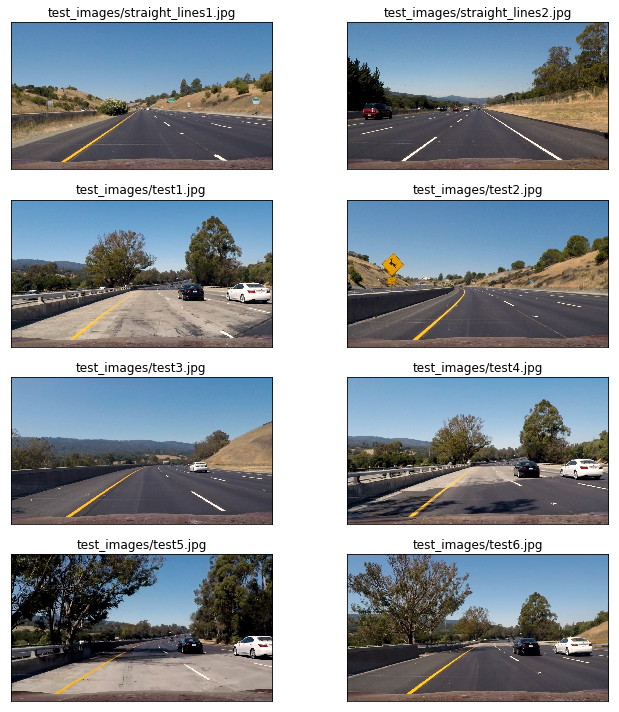

In [6]:
original_images = list(
    map(lambda img: load_image(img), 
        original_image_names)
)

show_image_list(img_list = original_images)

There are few immediately obvious challenges we need to be mindful of while building a generalized pipeline for deteting lanes in these images:  

1. While the lane lines are generally coloured white, they can also be yellow. 
2. While most of these images depict only light traffic, some of them have other cars in them and what's worse is that some cars are colored white! 
3. All of these images depict fairly straight patches of road. It is obviously possible for roads and therefore our lane lines to be curved.   

These are good things to know. Let's start building our pipeline. For testing our pipeline, we'll use just the first image (shown below).  

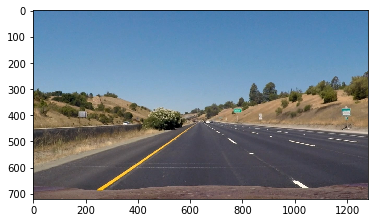

In [7]:
test_image = original_images[0]

plt.imshow(test_image)

---

## Step 1: Camera calibration

The process by which cameras produce 2D images of 3D objects isn't perfect; the shape and size of objects can change. Below is an example of a distorted image taken by a camera (left) and the same image undistorted (right).  

<figure>
 <img src="writeup_images/chessboard_undistort.jpg"/>
 <figcaption>
 <p></p> 
     
Before we can do anything, we need to first deal with this distortion. Specifically, we will use images of chessboards taken by our camera to figure out it's calibration. After that, we can undistort any image taken by our particular camera. This will allow us to get accurate and useful information out of them later on when perform lane line detection. 

In [8]:
# read in camera calibration images from directory

# img dir
camera_cal_img_dir = "camera_cal/"

# img names
camera_cal_image_names = (
    sorted(
        os.listdir(camera_cal_img_dir)
    )
)

# image paths
camera_cal_image_paths = list(
    map(lambda name: camera_cal_img_dir + name, 
        camera_cal_image_names)
)

# images
camera_cal_images = list(
    map(lambda img: load_image(img), 
        camera_cal_image_paths)
)

In [9]:
# show_image_list(
#     img_list = camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

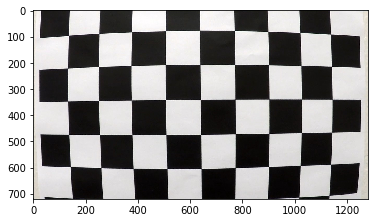

In [10]:
plt.imshow(camera_cal_images[0])

In [11]:
# grayscale images
gray_camera_cal_images = [
    cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in camera_cal_images
]

# set chessboard dimensions
dims = (9,6)

# find chessboard corners
chessboard_corners = [
    cv2.findChessboardCorners(image, dims, None) for image in gray_camera_cal_images
]

In [12]:
# verify chessboard corners have been correctly identified
# plt.imshow(
#     cv2.drawChessboardCorners(
#     camera_cal_images[0], 
#     dims, 
#     *chessboard_corners[0][::-1])
# )

Calculate correct camera matrix and distortion coefficients

In [13]:
# object points
objp = np.zeros(
    (np.prod(dims), 3), 
    np.float32
)

objp[:,:2] = np.mgrid[0:dims[0], 0:dims[1]].T.reshape(-1,2)

objpoints = [
    objp for corner_set in chessboard_corners if corner_set[0]
]

# image points
imgpoints = [
    corner_set[1] for corner_set in chessboard_corners if corner_set[0]
]

# extract camera calibration paramets
ret, mtx, dist, rvecs, tvecs = (
    cv2.calibrateCamera(
        objpoints, 
        imgpoints, 
        gray_camera_cal_images[0].shape[::-1], 
        None, 
        None)
)

In [14]:
def undistort(img, mtx, dist): 
    """
    undistort camera images
    """
    undistorted_img = cv2.undistort(
        img, 
        mtx, 
        dist, 
        None, 
        mtx
    )
    
    return undistorted_img

In [15]:
undistorted_camera_cal_images = list(
    map(lambda img: undistort(img, mtx, dist), 
        camera_cal_images)
)

In [16]:
# show_image_list(
#     img_list = undistorted_camera_cal_images,
#     img_labels = camera_cal_image_names, 
#     cols=5
# )

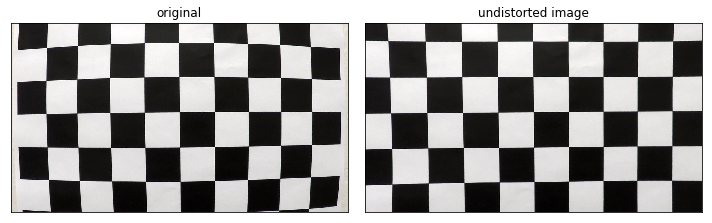

In [17]:
show_image_list(
    img_list=[
        camera_cal_images[0], undistorted_camera_cal_images[0], 
    ],
    img_labels=[
        'original', 'undistorted image'
    ], 
    cmap='gray',
    cols=2
)

Let's undistort our actual driving images. 

In [18]:
undistorted_image = undistort(
    img=test_image, 
    mtx=mtx, 
    dist=dist
)

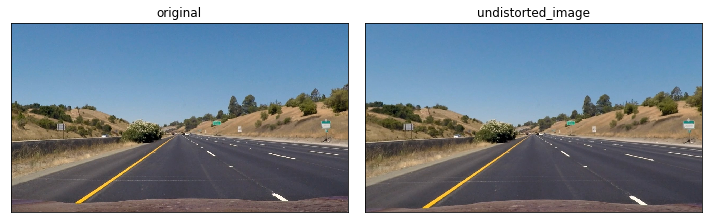

In [19]:
show_image_list(
    img_list=[
        test_image, undistorted_image, 
    ],
    img_labels=[
        'original', 'undistorted_image'
    ], 
    cmap='gray',
    cols=2
)

---

## Step 2: Convert image to HSL

There are a number of color models, below is a brief introduction to two of the most popular models in use today.   

#### RGB 

The most commonly used model is the RGB model which defines a color space in terms of three components:

- Red, which ranges from 0-255
- Green, which ranges from 0-255
- Blue, which ranges from 0-255

The RGB color model is additive i.e. Red, Green and Blue values are combined to reproduce other colors. 

<figure>
 <img src="writeup_images/rgb.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> RGB color model </p> 

#### HLS 

The HLS color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Lightness (also Luminance or Luminosity or Intensity). Ranges from 0 to 100% (from black to white).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).


<figure>
 <img src="writeup_images/hsl.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HLS color model </p> 
     
#### HSV 

The HSV color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).  
- Value: xxx

<figure>
 <img src="writeup_images/hsv.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HSV color model </p> 


There are other color models out there too including CMYK, and YUV. Like most images however, all of our images are in RBG format. So why are we talking about other color models? We suspect that it might be easier to isolate driving lanes in other color spaces than RGB. So let's have a look at our test images in HSL.    

In [20]:
def rgb(img_rgb, channel):
    """
    extracts specified channel from RGB image
    """
    
    if channel=='r':
        img_channel = img_rgb[:,:,0] 
    if channel=='g':
        img_channel = img_rgb[:,:,1]
    if channel=='b':
        img_channel = img_rgb[:,:,2]
    if channel==None:
        img_channel = img_rgb
    
    return img_channel

In [21]:
def hls(img, channel):
    """
    converts RGB image to HSL and extracts specified channel
    """
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if channel=='h':
        img_channel = img_hls[:,:,0] 
    if channel=='l':
        img_channel = img_hls[:,:,1]
    if channel=='s':
        img_channel = img_hls[:,:,2]
    if channel==None:
        img_channel = img_hls
    
    return img_channel

In [22]:
def hsv(img, channel):
    """
    converts RGB image to HSV and extracts specified channel
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if channel=='h':
        img_channel = img_hsv[:,:,0] 
    if channel=='s':
        img_channel = img_hsv[:,:,1]
    if channel=='v':
        img_channel = img_hsv[:,:,2]
    if channel==None:
        img_channel = img_hsv
    
    return img_channel

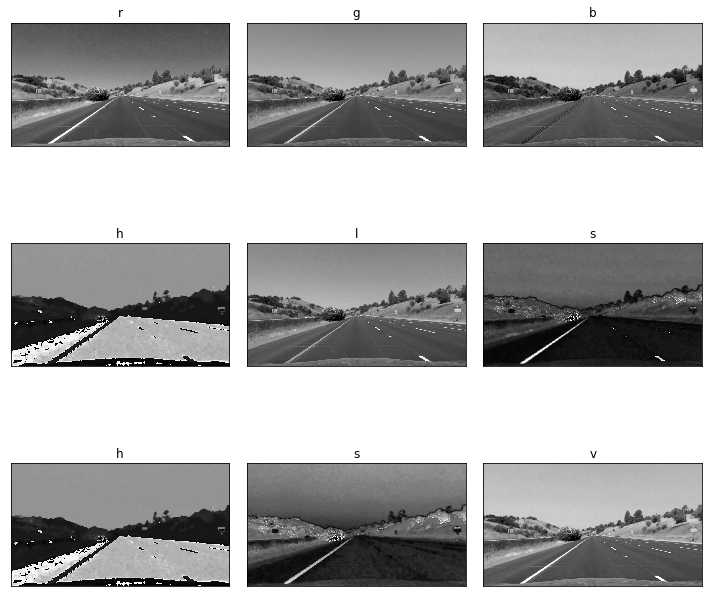

In [23]:
show_image_list(
    img_list=[
        rgb(undistorted_image, 'r'), rgb(undistorted_image, 'g'), rgb(undistorted_image, 'b'), 
        hls(undistorted_image, 'h'), hls(undistorted_image, 'l'), hls(undistorted_image, 's'), 
        hsv(undistorted_image, 'h'), hsv(undistorted_image, 's'), hsv(undistorted_image, 'v')
    ],
    img_labels=[
        'r', 'g', 'b',
        'h', 'l', 's', 
        'h', 's', 'v'
    ], 
    cmap='gray',
    cols=3
)

The **s**aturation channel from HLS looks best, we'll go with that.  

In [24]:
hls_s_image = hls(img=undistorted_image, channel='s')

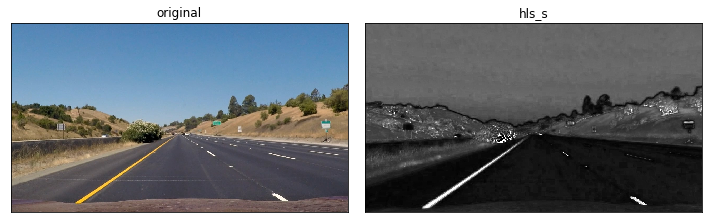

In [25]:
show_image_list(
    img_list=[
        test_image, hls_s_image, 
    ],
    img_labels=[
        'original', 'hls_s'
    ], 
    cmap='gray',
    cols=2
)

Another advantage of the S channel in HLS that we don't show here is that it is very robust to changing conditions.  

---

## Step 3: Gaussian blur

Gaussian blur is a commonly used pre-processing technique that does exactly what it sounds like it does.   

<figure>
 <img src="writeup_images/gaussian_blur.png"/>
 <figcaption>
 <p></p>  
     
We're going to use Gaussian blur to reduce the number of edges we detect later on. We have to be careful though. Too much blurring and it will become difficult to find any lines. We can control the amount of blurring by adjusting our kernel size.  

In [26]:
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [27]:
blur_image = gaussian_blur(hls_s_image)

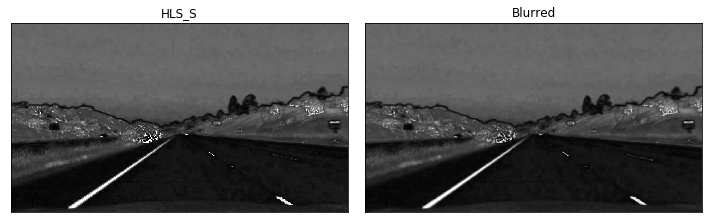

In [28]:
show_image_list(
    img_list=[
        hls_s_image, blur_image, 
    ],
    img_labels=[
        'HLS_S', 'Blurred'
    ], 
    cmap='gray',
    cols=2
)

Although its a little difficult to see here, the sharp jagged edges of our lane lines have become smoother and more continuous. This should help in a few stages when we try to detect edges.  

---

## Step 4: Thresholding

Thresholding is one of the most basic approaches to image segmentation. Essentially, it involves turning pixels on/off based on whether a pixel property satisfies a given threshold condition. The end result are **binary** images, which by definition contain significantly less noise.   

Below we explore a number of thresholding approaches.  

### Color thresholding  

Color thresholding is the easiest to understand. We've already explored thresholding individual RGB/HLS/HSV color channels. This time we'll threshold pixel values in our given channel. 

So for example, if we say we want to threshold for pixel values above 250 in an image, this means we  only want to retain pixels where the pixel value is greater than 250. In effect, we would end up retaining only the white elements of an image. Note that this isn't necessarily what we want given that lane lines can also be yellow.  

In [29]:
def color_threshold(img, thresh=(50, 255)):
    """
    thresholds a given single channel image
    """
    
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    return binary_output

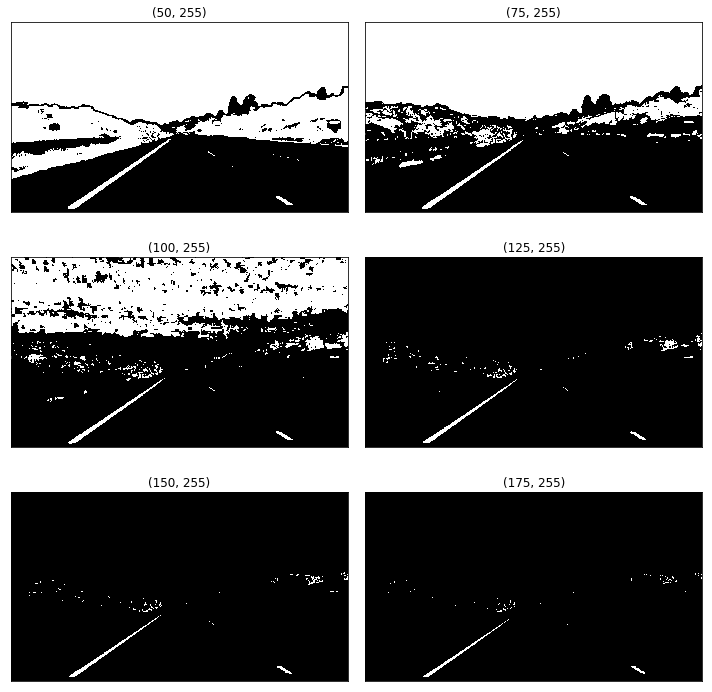

In [30]:
thresholds=[
    (50, 255),
    (75, 255),
    (100, 255),
    (125, 255),
    (150, 255),
    (175, 255)
    ]

show_image_list(
    img_list=[color_threshold(blur_image, threshold) for threshold in thresholds],
    img_labels=thresholds, 
    cmap='gray',
    cols=2
)

175, 255 it is. 

### Gradient thresholding  

Applying the Sobel operator to an image is a way of taking the derivative (i.e. gradient) of the image in the x or y direction. 

One way of thinking about how these operators work is to imagine a small window overlaid over a portion of your image. If the image is flat across that region, then the result (summing the element-wise product of the operator and corresponding image pixels) will be zero. If, instead, for example, you apply the Sobelx operator to a region of the image where values are rising from left to right, then the result will be positive, implying a positive derivative in the x direction. 

Taking the gradient in the y direction emphasizes edges closer to horizontal. 



Given that we expect our lane lines to be generally vertical, we'll see that taking the gradient in the y direction is more useful for our purposes.  

If you play around with the thresholds a bit, you'll find the x-gradient does a cleaner job of picking up the lane lines, but you can see the lines in the y-gradient as well.

In [31]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements 
    """
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x': 
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

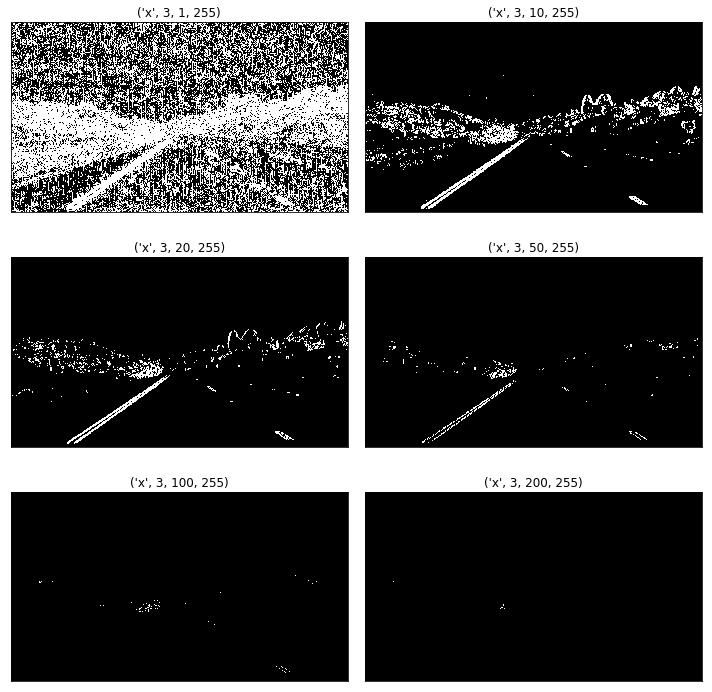

In [32]:
params=[
    ('x', 3, 1, 255),
    ('x', 3, 10, 255),
    ('x', 3, 20, 255),
    
    ('x', 3, 50, 255),
    ('x', 3, 100, 255),
    ('x', 3, 200, 255)
    ]

show_image_list(
    img_list=[
        abs_sobel_thresh(img = blur_image, 
                         orient = param[0], 
                         sobel_kernel = param[1], 
                         thresh = (param[2], param[3])
                        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=2
)

As we expected, the 'x' orientation is pretty useless for detecting driving lanes, irrespective of our threshold values.  

Let's try again using the 'y' orientation.  

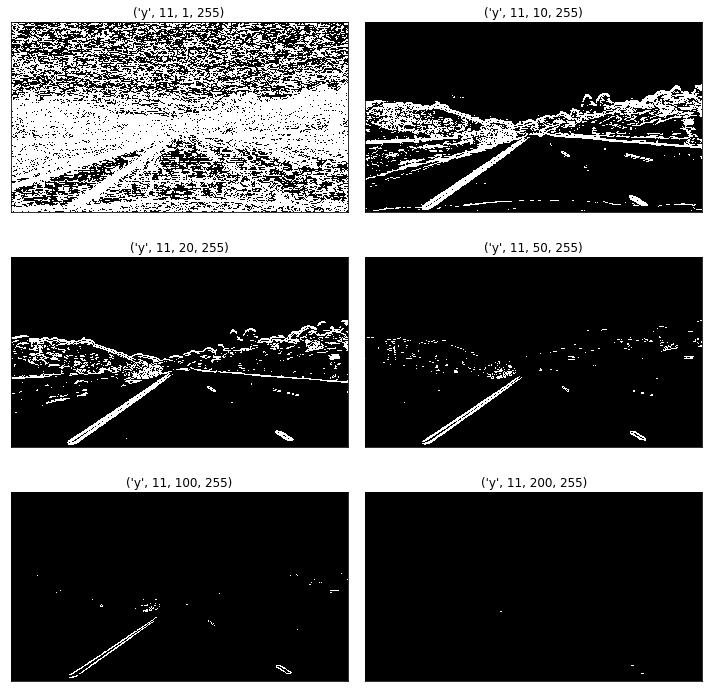

In [33]:
params=[
    ('y', 11, 1, 255),
    ('y', 11, 10, 255),
    ('y', 11, 20, 255),
    
    ('y', 11, 50, 255),
    ('y', 11, 100, 255),
    ('y', 11, 200, 255)
    ]

show_image_list(
    img_list=[
        abs_sobel_thresh(
            img = blur_image, 
            orient = param[0], 
            sobel_kernel = param[1], 
            thresh = (param[2], param[3])
            ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=2
)

This looks much better.  

### Magnitude thresholding  

With the result of the last quiz, you can now take the gradient in x or y and set thresholds to identify pixels within a certain gradient range. If you play around with the thresholds a bit, you'll find the x-gradient does a cleaner job of picking up the lane lines, but you can see the lines in the y-gradient as well.

In this next exercise, your goal is to apply a threshold to the overall magnitude of the gradient, in both x and y.  

In [34]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements
    """
    
    # Take the derivative in x and y
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the derivative or gradient
    abs_sobel_xy = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_xy/np.max(abs_sobel_xy))
    
    # Create a mask of 1's where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

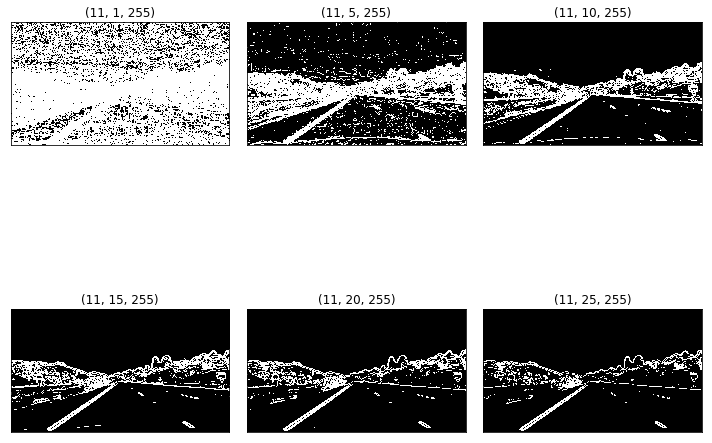

In [35]:
params=[
    (11, 1, 255),
    (11, 5, 255),
    (11, 10, 255),
    (11, 15, 255),
    (11, 20, 255),
    (11, 25, 255),
    ]

show_image_list(
    img_list=[
        mag_threshold(
            img = blur_image, 
            sobel_kernel = param[0], 
            thresh = (param[1], param[2])
        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

5,25,150 <- looks good

### Direction thresholding  

When you play around with the thresholding for the gradient magnitude in the previous exercise, you find what you might expect, namely, that it picks up the lane lines well, but with a lot of other stuff detected too. Gradient magnitude is at the heart of Canny edge detection, and is why Canny works well for picking up all edges.

In the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient.

The direction of the gradient is simply the inverse tangent (arctangent) of the y gradient divided by the x gradient:

arctan(sobel 
y
​	 /sobel 
x
​	 ).

Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, covering a range of −π/2 to π/2. An orientation of 0 implies a horizontal line and orientations of +/−π/2 imply vertical lines.

In [36]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    expects a single channel image
    sobel_kernel must be an odd number, choose a larger odd number to smooth gradient measurements
    """
    
    # Take the derivative in x and y
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Create a mask of where direction thresholds are met
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    return dir_binary

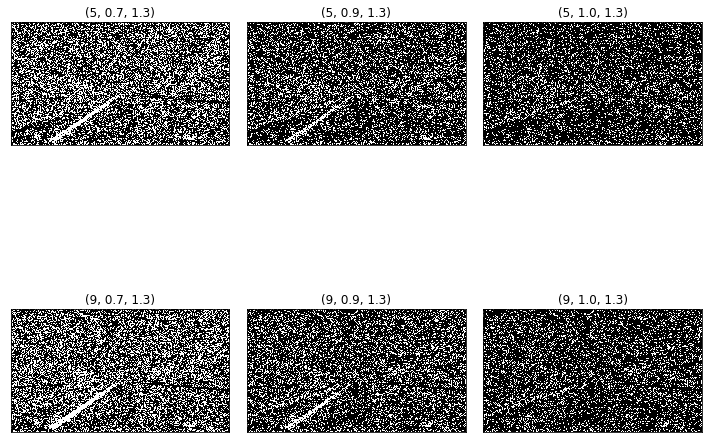

In [37]:
params=[
    (5, 0.7, 1.3),
    (5, 0.9, 1.3),
    (5, 1.0, 1.3),
    (9, 0.7, 1.3),
    (9, 0.9, 1.3),
    (9, 1.0, 1.3),
    ]

show_image_list(
    img_list=[
        dir_threshold(
            img = blur_image, 
            sobel_kernel = param[0], 
            thresh = (param[1], param[2])
        ) for param in params
    ],
    img_labels=params, 
    cmap='gray',
    cols=3
)

### Combining multiple thresholds  

We can combine multiple thresholds using an AND operation.  

In [38]:
def combine_thresholds(images): 
    """
    combines images thresholded in different ways
    """
    
    combined = np.zeros_like(images[1])
    
    length = len(images)
    
    if length==2:
        combined[(images[0]==1) & (images[1]==1)] = 1
        
    if length==3:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1)
                ] = 1
        
    if length==4:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1) &
                 (images[3]==1)
                ] = 1
        
    if length==5:
        combined[(images[0]==1) & 
                 (images[1]==1) &
                 (images[2]==1) &
                 (images[3]==1) &
                 (images[4]==1)
                ] = 1
        
    return combined

In [39]:
params=[
    color_threshold(
        img=blur_image, 
        thresh=(50,255)
    ), 
#      abs_sobel_thresh(
#         img = blur_image, 
#         orient = 'y', 
#         sobel_kernel = 11, 
#         thresh = (10, 255)
#     ), 
     mag_threshold(
         img = blur_image, 
         sobel_kernel = 11, 
         thresh = (10, 255)
     ), 
     dir_threshold(
         img = blur_image, 
         sobel_kernel = 9, 
         thresh = (0.7, 1.3)
     )
    
]

# show_image_list(
#     img_list=[
#         combine_thresholds(
#             images = [param for param in params]
#         )
#     ],
#     img_labels=['Preprocessed'], 
#     cmap='gray',
#     cols=1
# )

In [40]:
threshold_image = combine_thresholds(
    images = [param for param in params]
)

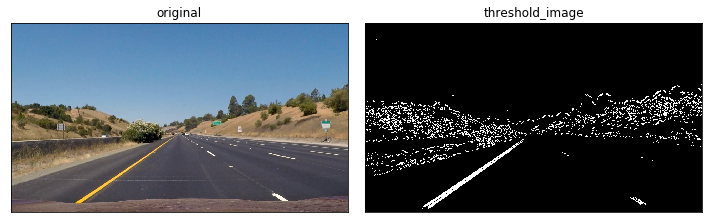

In [41]:
show_image_list(
    img_list=[
        test_image, threshold_image, 
    ],
    img_labels=[
        'original', 'threshold_image'
    ], 
    cmap='gray',
    cols=2
)

This is looking pretty good.  

## Step 5: Perspective Transform  

The image we have has been de-noised pretty well. We can now start thinking about finding lane lines. 

Because of where our camera is placed, we have a front-facing view, or perspective, of the road. This means that the lane in front of us looks smaller the further away it gets from our camera. 

Perspective transform is a technique for warping an image to get different views or perspectives. It would be useful for us if we could zoom in on the further away objects in our image, i.e. get a top-down view of the road. Some of our tasks later on will be easier to perform on this kind of view. 

For example, fitting a line and calculating the lane curvature will be easier with this view later on. Currently you'll notice that the left lane line is leaning towards the right in our test image. The right lane line is leaning towards the left. In fact, in the image it looks like the two lane lines will eventually converge. However, the reality is that they are both parallel. A top down perspective transform will show as much.  

Although not relevant for this project, this perspective is also useful for matching up a car's location with a map.  

Applying a perspective transform is very similar to what we did for undistorting an image. The only difference is that tnstead of mapping object points to image points, this time we'll be mapping points on an image to different desired points on an image with a new perspective.  

It should be noted that perspective transforms can be used for more than just creating a bird’s eye view representation of an image.  

<figure>
 <img src="writeup_images/perspective_transform.jpg"/>
 <figcaption>
 <p></p>  
     
First, we need to figure out what 4 points we want to warp our image about.  

In [42]:
# define a trapezoidal region of interest about our lane

# where we want our trapezoid to start and end along the y axis
min_y = 720
max_y = 455

# define x,y for 4 points
left_x1 = 190 
left_y1 = min_y

left_x2 = 585
left_y2 = max_y

right_x1 = 705
right_y1 = max_y

right_x2 = 1130
right_y2 = min_y

# define array of 4 points
# the order matters!
# first entry is the top-left
# second entry is the top-right
# third is the bottom-right
# fourth is the bottom-left

src = np.float32([ 
    [left_x2, left_y2],
    [right_x1, right_y1],
    [right_x2, right_y2],
    [left_x1, left_y1]
])

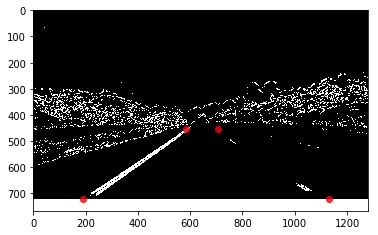

In [43]:
w, h = threshold_image.shape

# temp copy of image
temp = threshold_image.copy()

color = [255, 0, 0]
thickness = 10

# add lines
cv2.line(
    img = temp, 
    pt1 = (left_x1, left_y1), 
    pt2 = (left_x2, left_y2), 
    color = color, 
    thickness = thickness
)

cv2.line(
    img = temp, 
    pt1 = (left_x2, left_y2), 
    pt2 = (right_x1, right_y1), 
    color = color, 
    thickness = thickness
)

cv2.line(
    img = temp, 
    pt1 = (right_x1, right_y1), 
    pt2 = (right_x2, right_y2), 
    color = color, 
    thickness = thickness
)

cv2.line(
    img = temp, 
    pt1 = (right_x2, right_y2), 
    pt2 = (left_x1, left_y1), 
    color = color, 
    thickness = thickness
)

# plt.imshow(threshold_image, cmap='gray')
# plt.imshow(temp, alpha = 0.5)

plt.imshow(threshold_image, cmap='gray')
plt.scatter(src[:,0], src[:,1], color='red', alpha = 0.8)

define a matching set of 4 (destination) points

In [44]:
w = threshold_image.shape[1]
h = threshold_image.shape[0]

# offset from the sides
offset = 200

# first entry is the top-left
# second entry is the top-right
# third is the bottom-right
# fourth is the bottom-left
dst = np.float32([
    [offset, 0],
    [w - offset, 0],
    [w - offset, h], 
    [offset, h]
])

In [45]:
# Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse perspective transform
# We will need this later on when we want to 'unwarp' our image
Minv = cv2.getPerspectiveTransform(dst, src)

In [46]:
def adjustPerspective(img, M):
    """
    Adjust an image's perspective using the transformation matrix M
    """
    
    img_size = (img.shape[1], img.shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

In [47]:
warped = adjustPerspective(
    img=threshold_image
    , M=M
)

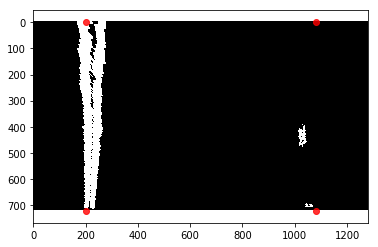

In [48]:
plt.imshow(warped, cmap='gray')
plt.scatter(dst[:,0], dst[:,1], color='red', alpha = 0.8)

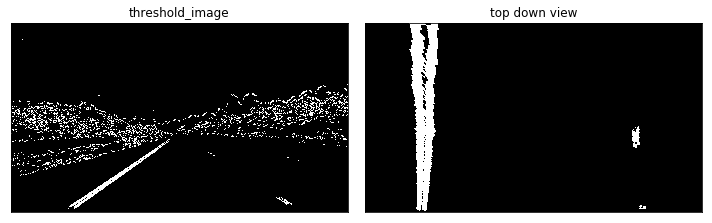

In [49]:
show_image_list(
    img_list=[
        threshold_image, warped, 
    ],
    img_labels=[
        'threshold_image', 'top down view'
    ], 
    cmap='gray',
    cols=2
)

Cool. 

## Step 6: Detect lane line pixels

We now have a thresholded warped image. We can now actually start mapping out the lane lines! We're going to try a number of ways to do this. 

### Peaks in a histogram

We have a binary image where the lane lines stand out pretty clearly. However, we still need to decide explicitly which pixels are part of the lines and also which pixels belong to the left and right lines respectively.  

One way of doing this is using a histogram of the total of the pixel values in each 'column' of pixels.   

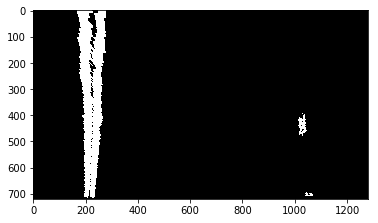

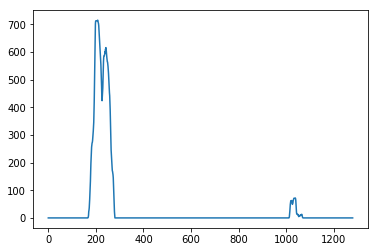

In [50]:
window = np.ones(35)

plt.imshow(warped, cmap='gray')
plt.show()

total_sum = np.sum(warped, axis=0)
plt.plot(total_sum)
plt.show()

Notice how the histogram peaks at exactly the same range of x values as our lane line pixels. This is because in our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x coordinates of the base of the lane lines. We will use these as starting points for where to search for the lane lines. 

Now we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.  

Suppose you've got a warped binary image called binary_warped and you want to find which "hot" pixels are associated with the lane lines. Here's a basic implementation of the method shown in the animation above. You should think about how you could improve this implementation to make sure you can find the lines as robustly as possible!

In [51]:
def fit_lane_lines(img, nwindows=9):
    """
    
    
    
    Arguments: 
        img: 
            must be binary
            must show a top down view of road
        nwindows: 
            number of sliding windows to use
    Returns: 
        left_fit: 
        right_fit:
    """

    # Assuming you have created a warped binary image called "img"
    # Take a histogram of the bottom half of the image
    # why bottom half? Cause lane line could be curving
    # and all we want to figure out is where to start drawing 
    # our lane lines from at the bottom of the image
    # this isn't using any histogram function
    # all its doing is returning an (ordered) array of the sum of each column in our image
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting points for our left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # determine based on where we have the most pixels in a column
    # best_defined_lane = np.argmax(histogram)

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(
            out_img,
            (win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),
            (0,255,0), 
            2
        ) 

        cv2.rectangle(
            out_img,
            (win_xright_low,win_y_low),
            (win_xright_high,win_y_high),
            (0,255,0), 
            2
        ) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = (
            (nonzeroy >= win_y_low) 
            & (nonzeroy < win_y_high) 
            & (nonzerox >= win_xleft_low) 
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]

        good_right_inds = (
            (nonzeroy >= win_y_low) 
            & (nonzeroy < win_y_high) 
            & (nonzerox >= win_xright_low) 
            & (nonzerox < win_xright_high)
        ).nonzero()[0] 

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Set minimum number of pixels found to create a line
    # if a lane is curving this might be too extreme
    # TODO: look for number of pixels in a range of adjacent x bins
    min_line_pix = 300
    
    # if the number of pixels in a given lane is too low to get a good line
    # use other lane if that is better
    if (histogram[rightx_base] < min_line_pix) & (histogram[leftx_base] > min_line_pix): 
        rightx = leftx + (midpoint + leftx_base)
        righty = lefty

    if (histogram[leftx_base] < min_line_pix) & (histogram[rightx_base] > min_line_pix): 
        leftx = rightx + (midpoint + lrightx_base)
        lefty = lefty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    color = (255,255,255)
    
    # draw left line
    pts = (list(zip(left_fitx, ploty)))
        
    cv2.polylines(
        out_img,
        [np.int32(pts)],
        False,
        color, 
        10
    )
    
    pts = (list(zip(right_fitx, ploty)))
    
    # draw right line
    cv2.polylines(
        out_img,
        [np.int32(pts)],
        False,
        color, 
        10
    )
        
    return out_img

In [52]:
detected_lanes = fit_lane_lines(img=warped)

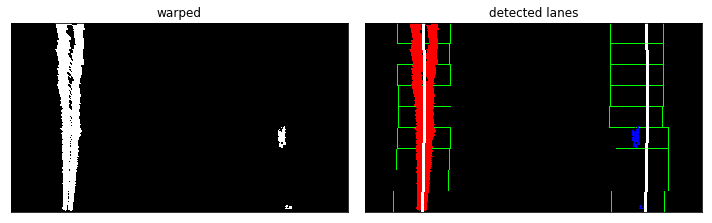

In [53]:
show_image_list(
    img_list=[
        warped, detected_lanes 
    ],
    img_labels=[
        'warped', 'detected lanes'
    ], 
    cmap='gray',
    cols=2
)

You can see we've clearly separated out the left and right lane pixels (coloured red and blue respectively) and we've got lines fitting our lane lines almost perfectly.   

We can be a bit more efficient about this though from a videos perspective. After the first frame, we'll know where the lane lines are. Instead of doing a blind search again for the lane lines, we can instead just search in a margin around the previous line position. A class object is more useful here.  

In [54]:
class Lane_line_detector:
    
    def __init__(self):
        
        midpoint_lane_x = None
        self.left_lane_x = None
        self.right_lane_x = None
        
        self.left_fit = None
        self.right_fit = None
        
        self.counter = 1
        
        # if the first frame of video has been processed
        self.first_frame_processed = False  
    
    def lane_position(self, img): 
        
        # Assuming you have created a warped binary image called "img"
        # Take a histogram of the bottom half of the image
        # why bottom half? Cause lane line could be curving
        # and all we want to figure out is where to start drawing 
        # our lane lines from at the bottom of the image
        # this isn't using any histogram function
        # all its doing is returning an (ordered) array of the sum of each column in our image
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)

        # find the peak of the left and right halves of the histogram
        # these will be the starting points for our left and right lines
        midpoint_x = np.int(histogram.shape[0]/2)
        left_x = np.argmax(histogram[:midpoint_x])
        right_x = np.argmax(histogram[midpoint_x:]) + midpoint_x
        
        # save
        self.midpoint_lane_x = midpoint_x
        self.left_lane_x = left_x
        self.right_lane_x = right_x
        
    def identify_lane_pixels(
        self,
        nonzerox, 
        nonzeroy, 
        left_lane_inds, 
        right_lane_inds, 
        histogram
    ):
        # Set minimum number of pixels found to create a line
        # if a lane is curving this might be too extreme
        # TODO: look for number of pixels in a range of adjacent x bins
        min_line_pix = 300
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # if the number of pixels in a given lane is too low to get a good line
        # use other lane if that is better
        if ((histogram[self.right_lane_x] < min_line_pix) 
            & (histogram[self.left_lane_x] > min_line_pix)): 
            rightx = leftx + (self.midpoint_lane_x + self.left_lane_x)
            righty = lefty

        if ((histogram[self.left_lane_x] < min_line_pix) 
            & (histogram[self.right_lane_x] > min_line_pix)): 
            leftx = rightx + (self.midpoint_lane_x + self.right_lane_x)
            lefty = lefty

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit
            
        
    def fit_lane_lines(self, img, nwindows=9):
        """



        Arguments: 
            img: 
                must be binary
                must show a top down view of road
            nwindows: 
                number of sliding windows to use
        Returns: 
            left_fit: 
            right_fit:
        """
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255

        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Set the width of the windows +/- margin
        margin = 100

        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Assuming you have created a warped binary image called "img"
        # Take a histogram of the bottom half of the image
        # why bottom half? Cause lane line could be curving
        # and all we want to figure out is where to start drawing 
        # our lane lines from at the bottom of the image
        # this isn't using any histogram function
        # all its doing is returning an (ordered) array of the sum of each column in our image
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting points for our left and right lines
        if not self.first_frame_processed:
            
            self.lane_position(img)

            # get lane position variables
            midpoint = self.midpoint_lane_x
            leftx_base = self.left_lane_x
            rightx_base = self.right_lane_x
            
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []
            
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Step through the windows one by one
            for window in range(nwindows):

                # Identify window boundaries in x and y (and right and left)
                win_y_low = img.shape[0] - (window+1)*window_height
                win_y_high = img.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Draw the windows on the visualization image
                cv2.rectangle(
                    out_img,
                    (win_xleft_low,win_y_low),
                    (win_xleft_high,win_y_high),
                    (0,255,0), 
                    2
                ) 

                cv2.rectangle(
                    out_img,
                    (win_xright_low,win_y_low),
                    (win_xright_high,win_y_high),
                    (0,255,0), 
                    2
                ) 

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = (
                    (nonzeroy >= win_y_low) 
                    & (nonzeroy < win_y_high) 
                    & (nonzerox >= win_xleft_low) 
                    & (nonzerox < win_xleft_high)
                ).nonzero()[0]

                good_right_inds = (
                    (nonzeroy >= win_y_low) 
                    & (nonzeroy < win_y_high) 
                    & (nonzerox >= win_xright_low) 
                    & (nonzerox < win_xright_high)
                ).nonzero()[0] 

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            self.left_fit, self.right_fit = self.identify_lane_pixels(
                nonzerox, 
                nonzeroy, 
                left_lane_inds, 
                right_lane_inds, 
                histogram
            )            
            
        else: 
            
            # Assuming you have already a good fit for your lane lines from 
            # the first frame processed
            # we don't need to do another blind search
            
            nonzero = img.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            margin = 100
            
            left_fit = self.left_fit
            right_fit = self.right_fit
            
            left_lane_inds = (
                (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))
            ) 

            right_lane_inds = (
                (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))
            )  

            self.left_fit, self.right_fit = self.identify_lane_pixels(
                nonzerox, 
                nonzeroy, 
                left_lane_inds, 
                right_lane_inds, 
                histogram
            )   
            
        # at this point, we should have left_fit and right_fit
        # regardless of whether this is the first frame or not
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        
        left_fitx = (
            self.left_fit[0]*ploty**2 + 
            self.left_fit[1]*ploty + 
            self.left_fit[2]
        )
        
        right_fitx = (
            self.right_fit[0]*ploty**2 + 
            self.right_fit[1]*ploty + 
            self.right_fit[2]
        )

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        color = (255,255,255)

        # draw left line
        pts = (list(zip(left_fitx, ploty)))

        cv2.polylines(
            out_img,
            [np.int32(pts)],
            False,
            color, 
            10
        )

        pts = (list(zip(right_fitx, ploty)))

        # draw right line
        cv2.polylines(
            out_img,
            [np.int32(pts)],
            False,
            color, 
            10
        )
        
        if self.first_frame_processed:
        
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            
            search_area_img = np.zeros_like(out_img)
            
            left_line_window1 = np.array(
                [np.transpose(np.vstack([left_fitx-margin, ploty]))]
            )
            
            left_line_window2 = np.array(
                [np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))]
            )
            
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            
            right_line_window1 = np.array(
                [np.transpose(np.vstack([right_fitx-margin, ploty]))]
            )
            
            right_line_window2 = np.array(
                [np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))]
            )
            
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(search_area_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(search_area_img, np.int_([right_line_pts]), (0,255, 0))
            
            out_img = cv2.addWeighted(out_img, 1, search_area_img, 0.2, 0)

        self.first_frame_processed = True
        
        return out_img

In [55]:
lane_line_detector = Lane_line_detector()

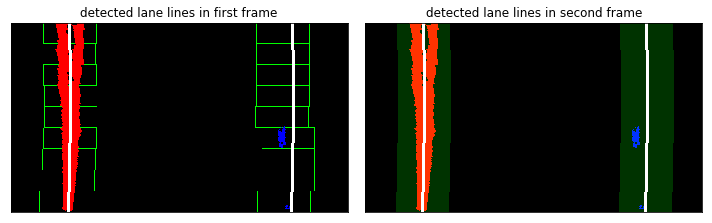

In [56]:
show_image_list(
    img_list=[
        lane_line_detector.fit_lane_lines(warped), lane_line_detector.fit_lane_lines(warped) 
    ],
    img_labels=[
        'detected lane lines in first frame', 'detected lane lines in second frame'
    ], 
    cmap='gray',
    cols=2
)

Nice, you can see that we didn't use the sliding windows approach in the second frame.  

### Sliding window search 

Another way to approach the sliding window method is to apply a convolution, which will 
maximize the number of "hot" pixels in each window. A convolution is the summation of the product of two separate signals, in our case the window template and the vertical slice of the pixel image.

You slide your window template across the image from left to right and any overlapping values are summed together, creating the convolved signal. The peak of the convolved signal is where there was the highest overlap of pixels and the most likely position for the lane marker.

Now let's try using convolutions to find the best window center positions in a thresholded road image. The code below allows you to experiment with using convolutions for a sliding window search function. Go ahead and give it a try.

In [57]:
# def window_mask(width, height, img_ref, center, level):
#     output = np.zeros_like(img_ref)
#     output[int(img_ref.shape[0] - (level + 1)*height):int(img_ref.shape[0] - level*height), max(0, int(center-width)):min(int(center+width), img_ref.shape[1])] = 1
#     return output

In [58]:
# class tracker():
    
#     def __init__(self, Mywindow_width, Mywindow_height, Mymargin, Mysmooth_factor = 15):
        
#         self.recent_centers = []
#         self.window_width = Mywindow_width
#         self.window_height = Mywindow_height
#         self.margin = Mymargin
#         self.smooth_factor = Mysmooth_factor
        
#     def find_window_centroids(self, warped):
        
#         window_width = self.window_width
#         window_height = self.window_height
#         margin = self.margin
        
#         window_centroids = []
#         window = np.ones(window_width)
        
#         l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
#         l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
#         r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
#         r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(warped.shape[1]/2)
        
#         window_centroids.append((l_center, r_center))
        
#         for level in range(1, (int)(warped.shape[0]/window_height)):
#             image_layer = np.sum(warped[int(warped.shape[0] - (level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
#             conv_signal = np.convolve(window, image_layer)
            
#             offset = window_width/2
#             l_min_index = int(max(l_center + offset - margin, 0))
#             l_max_index = int(min(l_center + offset + margin, warped.shape[1]))
#             l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
            
#             r_min_index = int(max(r_center + offset - margin, 0))
#             r_max_index = int(min(r_center + offset + margin, warped.shape[1]))
#             r_center = np.argmax(conv_signal[r_min_index: r_max_index]) + r_min_index - offset
            
#             window_centroids.append((l_center, r_center))
            
#         self.recent_centers.append(window_centroids)
        
#         return np.average(self.recent_centers[-self.smooth_factor:], axis = 0)

In [59]:
# window_width = 20
# window_height = 100
# curve_centers = tracker(Mywindow_width = 35, Mywindow_height = 80, Mymargin = 50, Mysmooth_factor = 100)

# window_centroids = curve_centers.find_window_centroids (warped)

# l_points = np.zeros_like(warped)
# r_points = np.zeros_like(warped)

# leftx = []
# rightx = []

# for level in range(0, len(window_centroids)):

#     leftx.append(window_centroids[level][0])
#     rightx.append(window_centroids[level][1])

#     l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
#     r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)

#     l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#     r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

# template = np.array(r_points + l_points, np.uint8)
# zero_channel = np.zeros_like(template)
# template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
# warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8)
# detected_lanes = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

In [60]:
# plt.imshow(detected_lanes)

## Step 7: Measuring curvature

In [61]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

## Step 8: Overlay detection on original image

In [62]:
class Lane_line_detector:
    
    def __init__(self):
        
        midpoint_lane_x = None
        self.left_lane_x = None
        self.right_lane_x = None
        
        self.left_lane_y = None
        self.right_lane_y = None
        
        self.left_coefficients = None
        self.right_coefficients = None
        
        self.first_frame_processed = False  
    
    def get_lane_position(self, img): 
        
        """
        Get position of left lane line, right lane line, middle point of lane
        """
        
        # Assuming you have created a warped binary image called "img"
        # Take a histogram of the bottom half of the image
        # why bottom half? Cause lane line could be curving
        # and all we want to figure out is where to start drawing 
        # our lane lines from at the bottom of the image
        # this isn't using any histogram function
        # all its doing is returning an (ordered) array of the sum of each column in our image
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)

        # find the peak of the left and right halves of the histogram
        # these will be the starting points for our left and right lines
        midpoint_x = np.int(histogram.shape[0]/2)
        left_x = np.argmax(histogram[:midpoint_x])
        right_x = np.argmax(histogram[midpoint_x:]) + midpoint_x
        
        # save
        self.midpoint_lane_x = midpoint_x
        self.left_lane_x = left_x
        self.right_lane_x = right_x
        
    def identify_lane_pixels(
        self,
        nonzerox, 
        nonzeroy, 
        left_lane_inds, 
        right_lane_inds):
        """
        Identify pixels as left or right lane pixels
        """
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        return leftx, lefty, rightx, righty
    
    def calc_lane_line_coefficients(
        self,
        nonzerox, 
        nonzeroy,
        left_lane_inds, 
        right_lane_inds, 
        histogram,
        ploty, 
        space='p'
    ): 
        """
        Get lane line coefficients
        
        Arguments: 
            space: 
                pixel space ('p') or real world space ('m' as metres)
        """
        
        leftx, lefty, rightx, righty = self.identify_lane_pixels(
            nonzerox, 
            nonzeroy, 
            left_lane_inds, 
            right_lane_inds
        )
        
        # Set minimum number of pixels found to create a line
        # if a lane is curving this might be too extreme
        # TODO: look for number of pixels in a range of adjacent x bins
        min_line_pix = 300
        
        # if the number of pixels in a given lane is too low to get a good line
        # use other lane if that is better
        if ((histogram[self.right_lane_x] < min_line_pix) 
            & (histogram[self.left_lane_x] > min_line_pix)): 
            rightx = leftx + (self.midpoint_lane_x + self.left_lane_x)
            righty = lefty

        if ((histogram[self.left_lane_x] < min_line_pix) 
            & (histogram[self.right_lane_x] > min_line_pix)): 
            leftx = rightx + (self.right_lane_x - self.midpoint_lane_x)
            lefty = righty

        # Fit a second order polynomial to each in pixel space
        if space=='p': 
            left_coefficients = np.polyfit(lefty, leftx, 2)
            right_coefficients = np.polyfit(righty, rightx, 2)
        
         # Fit a second order polynomial to each in real world space (metres)
        elif space=='m': 
            left_coefficients = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
            right_coefficients = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        return left_coefficients, right_coefficients
    
    
    def windows_step(
        self, 
        img, 
        nwindows, 
        leftx_current, 
        rightx_current, 
        nonzerox, 
        nonzeroy    
    ): 
        
        """
        Get pixels which are in good range of windows
        """
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set the width of the windows +/- margin
        margin = 100
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin

            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = (
                (nonzeroy >= win_y_low) 
                & (nonzeroy < win_y_high) 
                & (nonzerox >= win_xleft_low) 
                & (nonzerox < win_xleft_high)
            ).nonzero()[0]

            good_right_inds = (
                (nonzeroy >= win_y_low) 
                & (nonzeroy < win_y_high) 
                & (nonzerox >= win_xright_low) 
                & (nonzerox < win_xright_high)
            ).nonzero()[0] 

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        return (left_lane_inds, right_lane_inds)
            
    def get_lane_line_coefficients(self, img, ploty, nwindows=9, space='p'):
        """



        Arguments: 
            img: 
                must be binary
                must show a top down view of road
            nwindows: 
                number of sliding windows to use
        Returns: 
            left_coefficients: 
            right_coefficients:
        """

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Take a histogram of the bottom half of the image
        # and all we want to figure out is where to start drawing 
        # our lane lines from at the bottom of the image
        # this isn't using any histogram function
        # all its doing is returning an (ordered) array of the sum of each column in our image
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting points for our left and right lines
        if not self.first_frame_processed:
            
            self.get_lane_position(img)

            # get lane position variables
            midpoint = self.midpoint_lane_x
            leftx_base = self.left_lane_x
            rightx_base = self.right_lane_x

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            left_lane_inds, right_lane_inds = self.windows_step(
                img, 
                nwindows, 
                leftx_current, 
                rightx_current,
                nonzerox, 
                nonzeroy
            )

            left_coefficients, right_coefficients = self.calc_lane_line_coefficients(
                nonzerox, 
                nonzeroy,
                left_lane_inds, 
                right_lane_inds, 
                histogram,
                space='p', 
                ploty=None
            )
            
            self.left_coefficients = left_coefficients
            self.right_coefficients = right_coefficients
            
        else: 
                
            # Assuming you have already a good fit for your lane lines from 
            # the first frame processed
            # we don't need to do another blind search

            margin = 100
            
            left_lane_inds = (
                (nonzerox > (self.left_coefficients[0]*(nonzeroy**2) + 
                             self.left_coefficients[1]*nonzeroy + 
                             self.left_coefficients[2] - margin)) 
                & (nonzerox < (self.left_coefficients[0]*(nonzeroy**2) + 
                               self.left_coefficients[1]*nonzeroy + 
                               self.left_coefficients[2] + margin))
            ) 

            right_lane_inds = (
                (nonzerox > (self.right_coefficients[0]*(nonzeroy**2) + 
                             self.right_coefficients[1]*nonzeroy + 
                             self.right_coefficients[2] - margin)) 
                & (nonzerox < (self.right_coefficients[0]*(nonzeroy**2) + 
                               self.right_coefficients[1]*nonzeroy + 
                               self.right_coefficients[2] + margin))
            )  

            left_coefficients, right_coefficients = self.calc_lane_line_coefficients(
                nonzerox, 
                nonzeroy, 
                left_lane_inds, 
                right_lane_inds, 
                histogram, 
                ploty=None,
                space='p'
            )
            
        self.first_frame_processed = True
            
        return left_coefficients, right_coefficients
    
    def calc_curvature(self, binary_warped_img, y_eval, ploty): 
        
        # Fit new polynomials to x,y in world space
        left_coefficients_m, right_coefficients_m = self.get_lane_line_coefficients(
            binary_warped_img, ploty, space='m'
        )
        
        # Calculate the new radii of curvature
        left_curve_rad = ((1 + (2*left_coefficients_m[0]*y_eval*ym_per_pix + left_coefficients_m[1])**2)**1.5) / np.absolute(2*left_coefficients_m[0])
        
        right_curve_rad = ((1 + (2*right_coefficients_m[0]*y_eval*ym_per_pix + right_coefficients_m[1])**2)**1.5) / np.absolute(2*right_coefficients_m[0])

        return left_curve_rad, right_curve_rad
    
    def draw_lane(self, og_img, binary_warped_img, Minv):
        """
        Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
        """
        
        left_coefficients, right_coefficients = self.get_lane_line_coefficients(
            binary_warped_img, ploty=None, space='p'
        )
        
        yMax = og_img.shape[0]
        ploty = np.linspace(0, yMax - 1, yMax)
        color_warp = np.zeros_like(og_img).astype(np.uint8)

        # Calculate points
        left_fitx = left_coefficients[0]*ploty**2 + left_coefficients[1]*ploty + left_coefficients[2]
        right_fitx = right_coefficients[0]*ploty**2 + right_coefficients[1]*ploty + right_coefficients[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (og_img.shape[1], og_img.shape[0]))
        
        
        # calculate curvature
        left_curve_rad, right_curve_rad = self.calc_curvature(
            binary_warped_img = binary_warped_img, 
            y_eval = np.max(ploty), 
            ploty = ploty
        )
        
        # add curvature to image
        cv2.putText(
            img = og_img, 
            text = ("Radius of curvature: %s" %round(left_curve_rad, 0)), 
            org = (25,50), 
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale = 1, 
            color = [255, 255, 255], 
            thickness = 5
        )
        
        # add vehicle position wrt to left lane to image
        cv2.putText(
            img = og_img, 
            text = ("Vehicle is %s m left of the center" %round(left_curve_rad, 0)), 
            org = (25,100), 
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale = 1, 
            color = [255, 255, 255], 
            thickness = 5
        )

        return cv2.addWeighted(og_img, 1, newwarp, 0.3, 0)

In [63]:
lane_line_detector = Lane_line_detector()

In [64]:
lane_identified = lane_line_detector.draw_lane(test_image.copy(), warped.copy(), Minv)

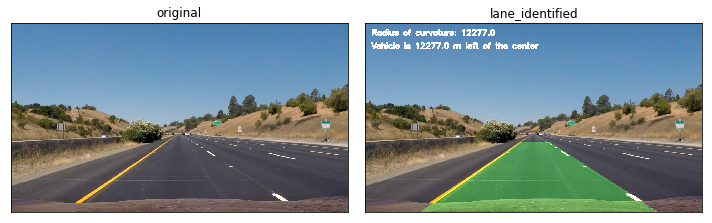

In [65]:
show_image_list(
    img_list=[
        test_image, lane_identified, 
    ],
    img_labels=[
        'original', 'lane_identified'
    ], 
    cmap='gray',
    cols=2
)

There we go. 

## Testing on images

Now let's combine all of the above functions into one with our best parameters.  

In [66]:
lane_line_detector = Lane_line_detector()

In [67]:
def process_image(img, show_plots=False):
    """
    One function to rule them all!
    """
    
    # undistory image 
    undistorted_image = undistort(img, mtx, dist)
    
    # convert image to hsl
    hls_s_image = hls(img=undistorted_image, channel='s')
    
    # apply Gaussian smoothing
    blur_image = gaussian_blur(hls_s_image)
    
    # threshold image
    params=[
#     color_threshold(
#         img=blur_image, 
#         thresh=(50,255)
#     ), 
     abs_sobel_thresh(
        img = blur_image, 
        orient = 'y', 
        sobel_kernel = 11, 
        thresh = (10, 255)
    ), 
     mag_threshold(
         img = blur_image, 
         sobel_kernel = 11, 
         thresh = (15, 255)
     ), 
#      dir_threshold(
#          img = blur_image, 
#          sobel_kernel = 9, 
#          thresh = (0.7, 1.3)
#      )
    ]

    threshold_image = combine_thresholds(
        images = [param for param in params]
    )
    
    # warp perspective to top down view
    warped_image = adjustPerspective(threshold_image, M)
    
    # lane on image
    final_image = lane_line_detector.draw_lane(img, warped_image, Minv)
        
    if show_plots==True:

        plt.imshow(image)
        plt.show()
        
        plt.imshow(image_hsl)
        plt.show()
        
        plt.imshow(image_gray, cmap='gray')
        plt.show()
        
        plt.imshow(blur_gray, cmap='gray')
        plt.show()
        
        

    else: 
        return final_image

Lets test our function on all the images to see how well it worked.  

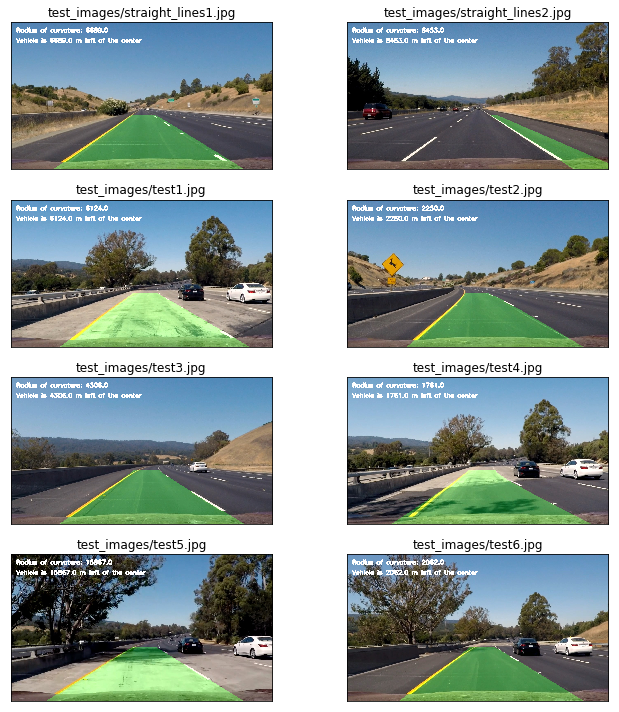

In [68]:
all_test_images = list(map(lambda img: process_image(img, show_plots=False), 
                           original_images.copy()))

show_image_list(img_list=all_test_images)

## Testing on videos

Drawing lanes over images is pretty cool but drawing lanes over video is awesome!

We'll test our solution on 3 different videos, ordered below by difficulty:

1. `project_video.mp4`

2. `challenge_video.mp4`

3. `harder_challenge_video.mp4`

In [69]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [70]:
def process_video(video_filepath, video_filename, lane_detector, plot=False):
    
    video_input = VideoFileClip(video_filepath + video_filename)
    video_output = video_input.fl_image(lane_detector)
    video_output.write_videofile(video_filename , audio=False)
    
    HTML(
        """<video width="800" height="400" controls>
        <source src="{0}">
        </video>"""
        .format(video_output)
    )

We'll try the one with the solid white lane on the right first. This is a fairly simple video. 

In [71]:
process_video("test_videos/", "project_video.mp4", process_image, plot=False)

[MoviePy] >>>> Building video project_video.mp4
[MoviePy] Writing video project_video.mp4


100%|█████████▉| 1260/1261 [03:36<00:00,  6.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.mp4 



Now for the challenge video, one with the solid yellow lane on the left. This one's more tricky!

In [72]:
process_video("test_videos/", "challenge_video.mp4", process_image, plot=False)

[MoviePy] >>>> Building video challenge_video.mp4
[MoviePy] Writing video challenge_video.mp4


100%|██████████| 485/485 [01:19<00:00,  5.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video.mp4 



Lastly, we'll try the harder challenge video.  

In [73]:
process_video("test_videos/", "harder_challenge_video.mp4", process_image, plot=False)

[MoviePy] >>>> Building video harder_challenge_video.mp4
[MoviePy] Writing video harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:36<00:00,  6.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video.mp4 



Humm the lines in our videos are quite jerky. Let's try and fix that. 